In [1]:
# Import packages
import os
import sys
import math
import random
import time
import pdb
import operator 
import copy
import numpy as np
import matplotlib.pyplot as plt
from numpy import matlib as mb
import torch
from envs import *
from my_utils import *
from state_action import *
from decision_making import *
from training_single_pi import *
import bandit_function as bf
np.set_printoptions(linewidth=250)
np.set_printoptions(formatter={'int': '{:2d}'.format})
np.set_printoptions(formatter={'float': '{:6.3f}'.format})

In [2]:
# Initialization
#random.seed(12312)
#np.random.seed(312321)
flag_clear_past_bandit_results = False # Clear history of past bandit learning
if flag_clear_past_bandit_results:
    LOOP_Training_Bandit = 0
else:
    LOOP_Training_Bandit = 100 # Number of offline training of bandit
LOOP_Testing = 50 # Number of testing bandit
LOOP = LOOP_Training_Bandit + LOOP_Testing # Numer of realization
slots_monitored = 2000;  # Total time slots to be monitored
Netw_topo_id = 3
env_parameter = env_init(Netw_topo_id)
t_slot = env_parameter.t_slot       # Time duration for a single slot in seconds
print('Total time monitored is %0.2f seconds' %(slots_monitored*t_slot))
print('Total time for bandit training is %0.2f minutes' %(slots_monitored*t_slot*LOOP_Training_Bandit/60))

Total time monitored is 80.00 seconds
Total time for bandit training is 133.33 minutes


In [3]:
# Scheme settings
scheme_setting_list = list();
class def_scheme_setting:
    def __init__(self):
        self.scheme_id = 0;
        self.Is_bandit_relay = False;
        self.Is_bandit_bw = False;
        self.Is_heuristic_tracking = False;
        self.Is_RL = False;
        self.legend = 'Max-weight + no tracking + no relay + random bw';
        self.color = 'r';
        return
    
# Scheme 0: Max-weight + no tracking + no relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 0;
scheme_setting.legend = 'Max-weight + no tracking + no relay + random bw';
scheme_setting.color = 'r';
scheme_setting_list.append(scheme_setting);

# Scheme 1: Max-weight + no tracking + no relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 1;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = True;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + no tracking + no relay + bandit bw';
scheme_setting.color = 'b';
scheme_setting_list.append(scheme_setting);

# Scheme 2: Max-weight + no tracking + bandit relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 2;
scheme_setting.Is_bandit_relay = True;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = False;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + no tracking + bandit relay + random bw';
scheme_setting.color = 'c';
scheme_setting_list.append(scheme_setting);

# Scheme 3: Max-weight + heuristic tracking + no relay + random bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 3;
scheme_setting.Is_bandit_relay = False;
scheme_setting.Is_bandit_bw = False;
scheme_setting.Is_heuristic_tracking = True;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + heuristic tracking + no relay + random bw';
scheme_setting.color = 'k';
scheme_setting_list.append(scheme_setting);

# Scheme 4: Max-weight + heuristic tracking + bandit relay + bandit bw (Our first proposal)
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 4;
scheme_setting.Is_bandit_relay = 1;
scheme_setting.Is_bandit_bw = 1;
scheme_setting.Is_heuristic_tracking = 1;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + heuristic tracking + bandit relay + bandit bw';
scheme_setting.color = 'm';
scheme_setting_list.append(scheme_setting);

# Scheme 5: Max-weight + heuristic tracking + no relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 5;
scheme_setting.Is_bandit_relay = 0;
scheme_setting.Is_bandit_bw = 1;
scheme_setting.Is_heuristic_tracking = 1;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + heuristic tracking + no relay + bandit bw';
scheme_setting.color = 'g';
scheme_setting_list.append(scheme_setting);

# Scheme 6: Max-weight + no tracking + bandit relay + bandit bw
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 6;
scheme_setting.Is_bandit_relay = 1;
scheme_setting.Is_bandit_bw = 1;
scheme_setting.Is_heuristic_tracking = 0;
scheme_setting.Is_RL = 0;
scheme_setting.legend = 'Max-weight + no tracking + bandit relay + bandit bw';
scheme_setting.color = 'y';
scheme_setting_list.append(scheme_setting);

# Scheme 7: Deep Reinforcement Learning (PPO)
scheme_setting = def_scheme_setting();
scheme_setting.scheme_id = 7;
scheme_setting.Is_bandit_relay = 0;
scheme_setting.Is_bandit_bw = 0;
scheme_setting.Is_heuristic_tracking = 0;
scheme_setting.Is_RL = 1;
scheme_setting.legend = 'Deep Reinforcement Learning (PPO)';
scheme_setting.color = 'darkorange';
scheme_setting_list.append(scheme_setting);

In [4]:
# General results vectors
N_schemes = len(scheme_setting_list);
#last_arrival_time = np.zeros(env_parameter.N_UE);
channel_X_history = np.zeros((slots_monitored,env_parameter.N_UE,env_parameter.N_UE));
Queue = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
Delay_dist = np.zeros((LOOP,slots_monitored+1,env_parameter.N_UE,N_schemes));
Throughput = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
UE_ID_evolution = np.zeros((slots_monitored,N_schemes));
npkts_arrival_evolution = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
npkts_departure_evolution = np.zeros((LOOP,slots_monitored,env_parameter.N_UE,N_schemes));
# Default state/action/output/banditBW/banditRelay list
state_list = list();
action_list = list();
lastOutput_list = list();
bandit_bw_para_list = list();
bandit_relay_para_list = list();
env_list = list();
for scheme_id in range(N_schemes):
    state_list.append(def_state(env_parameter));
    action_list.append(def_action(env_parameter));
    lastOutput_list.append(def_output(env_parameter)); 
    bandit_bw_para_list.append(def_bandit_bw_parameter(env_parameter));
    bandit_relay_para_list.append(def_bandit_relay_parameter(env_parameter));
    env_list.append(envs(env_parameter,slots_monitored));

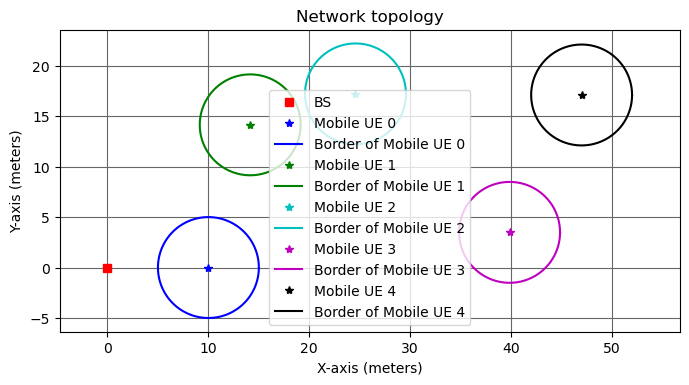

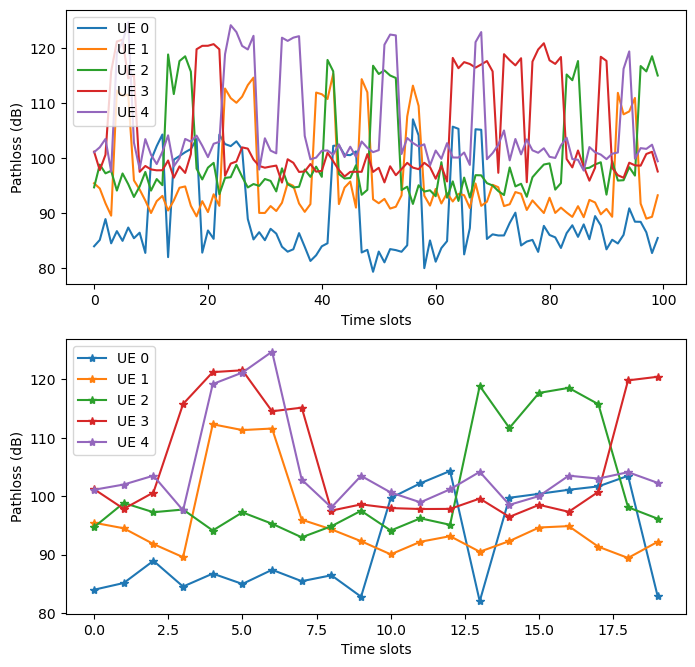

In [ ]:
# Evolution of system
envCommon = envs(env_parameter,slots_monitored);
plot_network_topology(envCommon.env_parameter)

# Load trained DRL decision maker
loadpath = os.getcwd()+'/trained_model_netwTopo'+str(Netw_topo_id)+'.pt'
checkpoint = torch.load(loadpath)
DRL_Decision_Maker = checkpoint['model']
DRL_Decision_Maker.load_state_dict(checkpoint['model_state_dict'])
DRL_Decision_Maker.eval()

tStart = time.time()
for loop in range(LOOP):
    #print(loop)
    envCommon.reset()
    state_list = list();
    action_list = list();
    lastOutput_list = list();
    if flag_clear_past_bandit_results:
        bandit_bw_para_list = list();
        bandit_relay_para_list = list();
    env_list = list();
    for scheme_id in range(N_schemes):
        state_list.append(def_state(env_parameter));
        action_list.append(def_action(env_parameter));
        lastOutput_list.append(def_output(env_parameter)); 
        if flag_clear_past_bandit_results:
            bandit_bw_para_list.append(def_bandit_bw_parameter(env_parameter));
            bandit_relay_para_list.append(def_bandit_relay_parameter(env_parameter));
        env_list.append(envs(env_parameter,slots_monitored));
        env_list[scheme_id].is_external_packet_arrival_process = True
        env_list[scheme_id].external_npkts_arrival = envCommon.npkts_arrival
        state_list[scheme_id] = env_list[scheme_id].reset();
    for ct in range(slots_monitored):  
        # Channel realization (Maybe to consider the correlation between time slots)
        channel = envCommon.channel_realization()
        envCommon.ct += 1 
        
        # Common packet arrival process
        common_npkts_arrival = envCommon.packet_arrival_process()
        
        # Loop of schemes
        for scheme_id in range(N_schemes):
            
            # Decisiion making
            if scheme_setting_list[scheme_id].Is_RL:
                Vval, pi = DRL_Decision_Maker.forward(state_list[scheme_id].to_ndarray_normalized())
                pi_dist = pi.detach().numpy()
                action_tmp, action_chosen_ndarray, action_chosen_index= choose_action(pi_dist, env_parameter)
                action_list[scheme_id] = action_tmp
            else:
                decision_making(loop, ct, scheme_id, state_list, action_list, lastOutput_list,\
                                bandit_bw_para_list, bandit_relay_para_list, scheme_setting_list, env_parameter)
            
            # Sanity check of action
            violation_tracking = state_list[scheme_id].Is_Tracking and \
            (action_list[scheme_id].UE_ID_BS2UE_Link != state_list[scheme_id].UE_ID_BS2UE_Link_Last_Slot)
            if violation_tracking:
                pdb.set_track()
                sys.exit('Error: constrainted violated: tracking order is not performed')
            violation_d2d_link = state_list[scheme_id].Is_D2D_Link_Active and\
            (action_list[scheme_id].UE_ID_BS2UE_Link == state_list[scheme_id].Tx_ID_D2D_Link or\
             action_list[scheme_id].UE_ID_BS2UE_Link == state_list[scheme_id].Rx_ID_D2D_Link or\
             action_list[scheme_id].Relay_ID == state_list[scheme_id].Tx_ID_D2D_Link or\
             action_list[scheme_id].Relay_ID == state_list[scheme_id].Rx_ID_D2D_Link)
            if violation_d2d_link:
                pdb.set_track()
                sys.exit('Error: constrainted violated: UEs in D2D link cannot be scheduled')
            
            
            # Interaction with enviroment
            last_state = copy.deepcopy(state_list[scheme_id])
            env_list[scheme_id].external_npkts_arrival = common_npkts_arrival
            state_list[scheme_id], output, reward, done = \
            env_list[scheme_id].step(state_list[scheme_id], action_list[scheme_id], channel);
            Queue[loop,ct,:,scheme_id] = env_list[scheme_id].Queue[ct,:]
            Delay_dist[loop,:,:,scheme_id] = env_list[scheme_id].delay_dist
            npkts_departure_evolution[loop,ct,:,scheme_id] = env_list[scheme_id].npkts_departure_evolution[ct,:]
            npkts_arrival_evolution[loop,ct,:,scheme_id] = env_list[scheme_id].npkts_arrival_evolution[ct,:]
            
            
            #########################################################################################
            #Save last output
            lastOutput_list[scheme_id] = output;
            
            # History of UE selection
            UE_ID_evolution[ct,scheme_id] = action_list[scheme_id].UE_ID_BS2UE_Link;  
            
            # Update bandit vectors during during phase
            if loop < LOOP_Training_Bandit:
                bandit_relay_para_list[scheme_id] = \
                bf.update_bandit_relay_para(bandit_relay_para_list[scheme_id],last_state,\
                                            action_list[scheme_id],output,env_parameter);
                bandit_bw_para_list[scheme_id] = \
                bf.update_bandit_bw_para(bandit_bw_para_list[scheme_id],\
                                         action_list[scheme_id],output,env_parameter);

    # Plot channel evolution
    if loop == 0:
        fig = plt.figure(figsize=(8,8),dpi=100);   
        ax_pathloss = fig.add_subplot(211)
        ax_pathloss_detailed = fig.add_subplot(212)
        slots_show1 = 100
        slots_show2 = 20
        for u in range(envCommon.env_parameter.N_UE): 
            ax_pathloss.plot(range(slots_show1),env_list[0].pathloss_history[0:slots_show1,u,u]+\
                             envCommon.channel_X_history[0:slots_show1,u,u], label='UE '+str(u));
            ax_pathloss_detailed.plot(range(slots_show2),env_list[0].pathloss_history[0:slots_show2,u,u]+\
                                      envCommon.channel_X_history[0:slots_show2,u,u], '-*',label='UE '+str(u));
        ax_pathloss.set_xlabel('Time slots');
        ax_pathloss.set_ylabel('Pathloss (dB)');
        ax_pathloss.legend();
        ax_pathloss_detailed.set_xlabel('Time slots');
        ax_pathloss_detailed.set_ylabel('Pathloss (dB)');
        ax_pathloss_detailed.legend();
        plt.show();
        #pdb.set_trace()
elapsed = time.time() - tStart
time_per_loop = elapsed/LOOP
print('Time per loop %0.2f second' %time_per_loop)

##### PLOT RESULTS #####

In [ ]:
# Mean queue length
Queue_test = Queue[LOOP_Training_Bandit-1:-1,:,:,:]
Throughput_test = Throughput[LOOP_Training_Bandit-1:-1,:,:,:]
npkts_departure_evolution_test = npkts_departure_evolution[LOOP_Training_Bandit-1:-1,:,:,:]
Delay_dist_test = Delay_dist[LOOP_Training_Bandit-1:-1,:,:,:]
mean_queue_length = np.mean(Queue_test,axis=2);
max_queue_length = np.max(Queue_test,axis=2);
min_queue_length = np.min(Queue_test,axis=2);
mean_throughput = np.sum(Throughput_test,axis=2);
mean_pkts_departure_evolution = np.sum(npkts_departure_evolution_test,axis=2);
if LOOP > 1:
    mean_queue_length = np.mean(mean_queue_length,axis=0);
    max_queue_length = np.mean(max_queue_length,axis=0);
    min_queue_length = np.mean(min_queue_length,axis=0);
    mean_throughput = np.mean(mean_throughput,axis=0);
    mean_pkts_departure_evolution = np.mean(mean_pkts_departure_evolution,axis=0);

In [ ]:
# CDF of average queue length
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.loc': 'upper right'})
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of Queue Length');
n_linspace = 100;
for scheme_id in range(N_schemes):
    [P, b] = cdf_dist_P_vs_b(mean_queue_length[:,scheme_id],n_linspace);
    plt.plot(b,P,label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged queue length q');
plt.ylabel('Prob (queue length > q)');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig('output/CDF_Queue_Length_pure_online.png',format='png')
else:
    plt.savefig('output/CDF_Queue_Length.png',format='png')
plt.show();

In [ ]:
# CDF of average queue length zoomed
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 18})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'legend.loc': 'upper right'})
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of Queue Length');
n_linspace = 100;
for scheme_id in ([2,4,6,7]):
    [P, b] = cdf_dist_P_vs_b(mean_queue_length[:,scheme_id],n_linspace);
    plt.plot(b,P,label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged queue length q');
plt.ylabel('Prob (queue length > q)');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig('output/CDF_Queue_Length_pure_online_zoom.png',format='png')
else:
    plt.savefig('output/CDF_Queue_Length_zoom.png',format='png')
plt.show();

In [ ]:
# Evolution of average queue length
plt.figure(figsize=(8,8),dpi=100)
plt.title('Evolution of average queue length')
slots_showed = slots_monitored;
for scheme_id in range(N_schemes):
    plt.plot(range(slots_showed),mean_queue_length[0:slots_showed,scheme_id],\
         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Time slot index');
plt.ylabel('Average queue length');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig('output/Evolution_queue_length_pure_online.png',format='png')
else:
    plt.savefig('output/Evolution_queue_length.png',format='png')
plt.show();

In [ ]:
# Evolution of average queue length zoomed
plt.figure(figsize=(8,8),dpi=100)
plt.title('Evolution of average queue length')
slots_showed = slots_monitored;
for scheme_id in ([2,4,6,7]):
#for scheme_id in ([4,6]):
    plt.plot(range(slots_showed),mean_queue_length[0:slots_showed,scheme_id],\
         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Time slot index');
plt.ylabel('Average queue length');
plt.legend();
if flag_clear_past_bandit_results:
    plt.savefig('output/Evolution_queue_length_pure_online_zoom.png',format='png')
else:
    plt.savefig('output/Evolution_queue_length_zoom.png',format='png')
plt.show();

In [ ]:
# CDF of average delay length
ave_Delay_dist = np.squeeze(np.mean(np.mean(Delay_dist_test,axis=2),axis=0))
ave_Delay_dist = ave_Delay_dist/np.sum(ave_Delay_dist,axis=0)
ave_Delay_CDF = np.cumsum(ave_Delay_dist,axis=0)
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of delay (slots)')
max_delay_to_show = slots_monitored+1
max_delay_to_show = 300
max_delay_to_show = min(max_delay_to_show,slots_monitored+1)
for scheme_id in range(N_schemes):
    plt.plot(range(max_delay_to_show),ave_Delay_CDF[0:max_delay_to_show,scheme_id],\
             label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged delay in slots t')
plt.ylabel('Prob (delay <= t)')
plt.rcParams.update({'legend.loc': 'lower right'})
plt.legend()
if flag_clear_past_bandit_results:
    plt.savefig('output/CDF_delay_pure_online.png',format='png')
else:
    plt.savefig('output/CDF_delay.png',format='png')
plt.show()

In [ ]:
# CDF of average delay length
plt.figure(figsize=(8,8),dpi=100)
plt.title('CDF of delay (slots)')
max_delay_to_show = 50
max_delay_to_show = min(max_delay_to_show,slots_monitored+1)
#for scheme_id in range(N_schemes):
for scheme_id in ([2,4,6,7]):
    plt.plot(range(max_delay_to_show),ave_Delay_CDF[0:max_delay_to_show,scheme_id],\
             label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
plt.xlabel('Averaged delay in slots t')
plt.ylabel('Prob (delay <= t)')
plt.rcParams.update({'legend.loc': 'lower right'})
plt.legend()
if flag_clear_past_bandit_results:
    plt.savefig('output/CDF_delay_pure_online_zoom.png',format='png')
else:
    plt.savefig('output/CDF_delay_zoom.png',format='png')
plt.show()

In [ ]:
# # Evolution of packet delivered
# plt.figure(figsize=(7,7),dpi=100)
# plt.title('Evolution of packet delivered');
# slots_showed = slots_monitored;
# for scheme_id in range(N_schemes):
#     plt.plot(range(slots_showed),mean_pkts_departure_evolution[0:slots_showed,scheme_id],\
#          label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# plt.xlabel('Time slot index');
# plt.ylabel('Number of packets delivered');
# plt.legend();
# plt.show();

In [ ]:
# # Evolution of average system throughput
# mean_throughput_per_user = np.mean(Throughput,axis=0);
# plt.figure(figsize=(7,7),dpi=100)
# plt.title('evolution of average system throughput');
# slots_showed = slots_monitored;
# for scheme_id in [0,4]:
#     plt.plot(range(slots_showed),mean_throughput[0:slots_showed,scheme_id],\
#         label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# #     plt.plot(range(slots_showed),mean_throughput_per_user[0:slots_showed,1,scheme_id],\
# #          label=scheme_setting_list[scheme_id].legend,c=scheme_setting_list[scheme_id].color);
# plt.xlabel('Time slot index');
# plt.ylabel('Average system throughput');
# plt.legend();
# plt.show();

In [ ]:
arrival_per_UE =  env_parameter.lambda_vec * env_parameter.t_slot
print('\nTheoretical arrival per UE is \n', arrival_per_UE)
theo_arr_npkts = np.sum(env_parameter.lambda_vec * env_parameter.t_slot)
print('\nTheoretical arrival packets is: \n',theo_arr_npkts)
simulated_arr_npkts = np.mean(np.sum(npkts_arrival_evolution,axis=2))
print('\nSimulated arrival packets is: \n',theo_arr_npkts)
ave_depart_npkt = np.mean(np.mean(np.sum(npkts_departure_evolution[:,-100:-1,:,:],axis=2),axis=0),axis=0)
print('\nAverage departed packets/slot in last 100 slots\n',ave_depart_npkt)
final_queue_length = np.mean(np.mean(Queue[:,-1,:,:],axis=1),axis=0)
print('\nFinal average queue length is:\n', final_queue_length)
# Average delay in slots
np.sum(ave_Delay_dist[:,7] * np.asarray(range(2001))) 
print('Average delay in slots')
ave_delay_in_slots = np.sum(np.multiply(np.transpose(ave_Delay_dist),np.asarray(range(2001))),axis = 1)
print('\nAverage delay in slots is: \n', ave_delay_in_slots)

In [ ]:
decay_rate = 0.95
0.001*decay_rate**(1000/20)

In [ ]:
# from study_statistic import *
# slots = 200
# LOOP = 50
# outage, ue_velocity_vec, ue_selfrotate_vec, env_parameter = calculate_outage_statistic(slots, LOOP)
# plot_outage_trend(outage, ue_velocity_vec, ue_selfrotate_vec, env_parameter)

In [ ]:
# from study_statistic import *
# slots = 200
# LOOP = 50
# reff_statistic, final_eff_coeff, outage_coeff, env_parameter = calculate_ground_truth_optimal_beamwidth(slots, LOOP)
# plot_reff_statistic(reff_statistic, final_eff_coeff, outage_coeff, env_parameter)

In [ ]:
from envs import *
env_parameter = env_init(Netw_topo_id=2)
plot_network_topology(env_parameter)